In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [1]:
import numpy as np
import os
import cv2
import pickle
import matplotlib.pyplot as plt
import tensorflow as tf
import random

In [2]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 200
def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [3]:
train = get_training_data('/content/drive/My Drive/Kaggle_Data/chest_xray/chest_xray/train')
test = get_training_data('/content/drive/My Drive/Kaggle_Data/chest_xray/chest_xray/test')
val = get_training_data('/content/drive/My Drive/Kaggle_Data/chest_xray/chest_xray/val')

OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



In [12]:
pnenumonia = 0 
normal = 0 

for i, j in train:
    if j == 0:
        pnenumonia+=1
    else:
        normal+=1
        
print('Pneumonia:', pnenumonia)
print('Normal:', normal)
print('Pneumonia - Normal:', pnenumonia-normal)
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Pneumonia: 3875
Normal: 1341
Pneumonia - Normal: 2534


In [43]:
X = []
y = []

for feature, label in train:
    X.append(feature)
    y.append(label)

for feature, label in test:
    X.append(feature)
    y.append(label)
    
for feature, label in val:
    X.append(feature)
    y.append(label)


# resize data for deep learning 
X = np.array(X).reshape(-1, img_size, img_size, 1)
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=32)

In [44]:
X_train = X_train.reshape(X_train.shape[0],-1).T
X_test = X_test.reshape(X_test.shape[0],-1).T
X_train = X_train / 255
X_test = X_test / 255
X_val = X_val / 255
print(X_train.shape)
print(y_train.shape)

(40000, 3747)
(3747,)


In [45]:
y_train = np.array(y_train).reshape(-1,1)
y_train = y_train.T
print(y_train.shape)

(1, 3747)


In [14]:
# good for balancing out disproportions in the dataset 
datagen = ImageDataGenerator(
        featurewise_center=False, 
        samplewise_center=False,  
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,  
        rotation_range=90, 
        zoom_range = 0.1, 
        width_shift_range=0.1,  
        height_shift_range=0.1,  
        horizontal_flip=True,  
        vertical_flip=True)  

datagen.fit(X_train)

In [15]:
def sigmoid(Z):
    """
    Implements the sigmoid activation in numpy
    
    Arguments:
    Z -- numpy array of any shape
    
    Returns:
    A -- output of sigmoid(z), same shape as Z
    cache -- returns Z as well, useful during backpropagation
    """
    
    A = 1/(1+np.exp(-Z))
    cache = Z
    
    return A, cache

In [16]:
def relu(Z):
    """
    Implement the RELU function.
    Arguments:
    Z -- Output of the linear layer, of any shape
    Returns:
    A -- Post-activation parameter, of the same shape as Z
    cache -- a python dictionary containing "A" ; stored for computing the backward pass efficiently
    """
    
    A = np.maximum(0,Z)
    
    assert(A.shape == Z.shape)
    
    cache = Z 
    return A, cache

In [17]:
def relu_backward(dA, cache):
    """
    Implement the backward propagation for a single RELU unit.
    Arguments:
    dA -- post-activation gradient, of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently
    Returns:
    dZ -- Gradient of the cost with respect to Z
    """
    
    Z = cache
    dZ = np.array(dA, copy=True) # just converting dz to a correct object.
    
    # When z <= 0, you should set dz to 0 as well. 
    dZ[Z <= 0] = 0
    
    assert (dZ.shape == Z.shape)
    
    return dZ

In [18]:
def sigmoid_backward(dA, cache):
    """
    Implement the backward propagation for a single SIGMOID unit.
    Arguments:
    dA -- post-activation gradient, of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently
    Returns:
    dZ -- Gradient of the cost with respect to Z
    """
    
    Z = cache
    
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    
    assert (dZ.shape == Z.shape)
    
    return dZ

In [35]:
### CONSTANTS DEFINING THE MODEL ####
n_x = 40000     # num_px * num_px * 3
n_h = 7
n_y = 1
layers_dims = (n_x, n_h, n_y)

In [20]:
def initialize_parameters(layer_dims):
    """
    Arguments:
    layer_dims -- python array (list) containing the dimensions of each layer in our network
    
    Returns:
    parameters -- python dictionary containing your parameters "W1", "b1", ..., "WL", "bL":
                    Wl -- weight matrix of shape (layer_dims[l], layer_dims[l-1])
                    bl -- bias vector of shape (layer_dims[l], 1)
    """
    
    np.random.seed(3)
    parameters = {}
    L = len(layer_dims)            # number of layers in the network

    for l in range(1, L):
        
        parameters['W' + str(l)] = np.random.randn(layer_dims[l],layer_dims[l-1])*0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l],1))
        
        
        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l-1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))

        
    return parameters

In [21]:
def linear_forward(A, W, b):
    """
    Implement the linear part of a layer's forward propagation.

    Arguments:
    A -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)

    Returns:
    Z -- the input of the activation function, also called pre-activation parameter 
    cache -- a python tuple containing "A", "W" and "b" ; stored for computing the backward pass efficiently
    """
    
    
    Z = np.dot(W,A)+b
    
    
    assert(Z.shape == (W.shape[0], A.shape[1]))
    cache = (A, W, b)
    
    return Z, cache

In [22]:
def linear_activation_forward(A_prev, W, b, activation):
    """
    Implement the forward propagation for the LINEAR->ACTIVATION layer

    Arguments:
    A_prev -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"

    Returns:
    A -- the output of the activation function, also called the post-activation value 
    cache -- a python tuple containing "linear_cache" and "activation_cache";
             stored for computing the backward pass efficiently
    """
    
    if activation == "sigmoid":
        # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
        
        Z, linear_cache = linear_forward(A_prev,W,b)
        A, activation_cache = sigmoid(Z)
        
    
    elif activation == "relu":
        # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
        
        Z, linear_cache = linear_forward(A_prev,W,b)
        A, activation_cache = relu(Z)
        
    
    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache, activation_cache)

    return A, cache

In [23]:
def compute_cost(AL, Y):
    """
    Implement the cost function defined by equation (7).

    Arguments:
    AL -- probability vector corresponding to your label predictions, shape (1, number of examples)
    Y -- true "label" vector (for example: containing 0 if non-cat, 1 if cat), shape (1, number of examples)

    Returns:
    cost -- cross-entropy cost
    """
    
    m = Y.shape[1]

    # Compute loss from aL and y.
    
    cost = -1/m * (np.sum(Y*np.log(AL)+((1-Y)*np.log(1-AL))))
    
    
    cost = np.squeeze(cost)      # To make sure your cost's shape is what we expect (e.g. this turns [[17]] into 17).
    assert(cost.shape == ())
    
    return cost

In [24]:
def linear_backward(dZ, cache):
    """
    Implement the linear portion of backward propagation for a single layer (layer l)

    Arguments:
    dZ -- Gradient of the cost with respect to the linear output (of current layer l)
    cache -- tuple of values (A_prev, W, b) coming from the forward propagation in the current layer

    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    A_prev, W, b = cache
    m = A_prev.shape[1]

    
    dW = 1/m *(np.dot(dZ,A_prev.T))
    db = 1/m * np.sum(dZ,axis = 1,keepdims = True)
    dA_prev = np.dot(W.T,dZ)
    #dA_prev = sum( [W[i][0]*dZ[i] for i in range(len(dZ))] )
    
    
    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)
    
    return dA_prev, dW, db

In [25]:
def linear_activation_backward(dA, cache, activation):
    """
    Implement the backward propagation for the LINEAR->ACTIVATION layer.
    
    Arguments:
    dA -- post-activation gradient for current layer l 
    cache -- tuple of values (linear_cache, activation_cache) we store for computing backward propagation efficiently
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"
    
    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    linear_cache, activation_cache = cache
    
    if activation == "relu":
        
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = (linear_backward(dZ,linear_cache))
        
        
    elif activation == "sigmoid":
        
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = (linear_backward(dZ,linear_cache))
        
    
    return dA_prev, dW, db

In [26]:
def update_parameters(parameters, grads, learning_rate):
    """
    Update parameters using gradient descent
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    grads -- python dictionary containing your gradients, output of L_model_backward
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
                  parameters["W" + str(l)] = ... 
                  parameters["b" + str(l)] = ...
    """
    
    L = len(parameters) // 2 # number of layers in the neural network

    # Update rule for each parameter. Use a for loop.
    
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)]- learning_rate*grads['dW'+str(l+1)]
        parameters["b" + str(l+1)] =parameters["b" + str(l+1)] - learning_rate*grads['db'+str(l+1)]
    
    return parameters

In [27]:
def two_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):
    """
    Implements a two-layer neural network: LINEAR->RELU->LINEAR->SIGMOID.
    
    Arguments:
    X -- input data, of shape (n_x, number of examples)
    Y -- true "label" vector (containing 1 if cat, 0 if non-cat), of shape (1, number of examples)
    layers_dims -- dimensions of the layers (n_x, n_h, n_y)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- If set to True, this will print the cost every 100 iterations 
    
    Returns:
    parameters -- a dictionary containing W1, W2, b1, and b2
    """
    
    np.random.seed(1)
    grads = {}
    costs = []                              # to keep track of the cost
    m = X.shape[1]                           # number of examples
    (n_x, n_h, n_y) = layers_dims
    
    # Initialize parameters dictionary, by calling one of the functions you'd previously implemented
    
    parameters = initialize_parameters(layers_dims)
    
    
    # Get W1, b1, W2 and b2 from the dictionary parameters.
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    # Loop (gradient descent)

    for i in range(0, num_iterations):

        # Forward propagation: LINEAR -> RELU -> LINEAR -> SIGMOID. Inputs: "X, W1, b1, W2, b2". Output: "A1, cache1, A2, cache2".
        
        #minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)
        A1, cache1 = linear_activation_forward(X, W1, b1, 'relu')
        A2, cache2 = linear_activation_forward(A1,W2,b2,'sigmoid')
        
        
        # Compute cost

        cost = compute_cost(A2, Y)
        
        
        # Initializing backward propagation
        dA2 = - (np.divide(Y, A2) - np.divide(1 - Y, 1 - A2))
        
        # Backward propagation. Inputs: "dA2, cache2, cache1". Outputs: "dA1, dW2, db2; also dA0 (not used), dW1, db1".

        
        dA1, dW2, db2 =  linear_activation_backward(dA2, cache2, activation='sigmoid')
        dA0, dW1, db1 =  linear_activation_backward(dA1, cache1, activation='relu')
        

        
        # Set grads['dWl'] to dW1, grads['db1'] to db1, grads['dW2'] to dW2, grads['db2'] to db2
        grads['dW1'] = dW1
        grads['db1'] = db1
        grads['dW2'] = dW2
        grads['db2'] = db2
        
        # Update parameters.

        parameters = update_parameters(parameters, grads, learning_rate)


        # Retrieve W1, b1, W2, b2 from parameters
        W1 = parameters["W1"]
        b1 = parameters["b1"]
        W2 = parameters["W2"]
        b2 = parameters["b2"]
        
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if print_cost and i % 100 == 0:
            costs.append(cost)
       
    # plot the cost

    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

Cost after iteration 0: 0.6931839048837843
Cost after iteration 100: 0.5220971766319019
Cost after iteration 200: 0.40562120891556175
Cost after iteration 300: 0.3022728546765306
Cost after iteration 400: 0.256503214972069
Cost after iteration 500: 0.22804209172628362
Cost after iteration 600: 0.20923142513966264
Cost after iteration 700: 0.1978819525599206
Cost after iteration 800: 0.18722098038342064
Cost after iteration 900: 0.1808252173044148
Cost after iteration 1000: 0.18486362235710502
Cost after iteration 1100: 0.17448230578772086
Cost after iteration 1200: 0.1586366333553558
Cost after iteration 1300: 0.2038832147643131
Cost after iteration 1400: 0.14927854282082217
Cost after iteration 1500: 0.16539251398317553
Cost after iteration 1600: 0.14530866437129233
Cost after iteration 1700: 0.14328840959630434
Cost after iteration 1800: 0.14290894912690566
Cost after iteration 1900: 0.14036869951283776
Cost after iteration 2000: 0.13829498957294775
Cost after iteration 2100: 0.13645

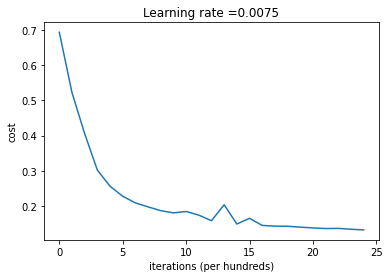

In [46]:
parameters = two_layer_model(X_train, y_train, layers_dims = (n_x, n_h, n_y), num_iterations = 2500, print_cost=True)

In [55]:
def predict(X, y, parameters):
    """
    This function is used to predict the results of a  L-layer neural network.
    
    Arguments:
    X -- data set of examples you would like to label
    parameters -- parameters of the trained model
    
    Returns:
    p -- predictions for the given dataset X
    """
    
    m = X.shape[1]
    n = len(parameters) // 2 # number of layers in the neural network
    p = np.zeros((1, m),dtype=int)
    
    # Forward propagation
    probas, caches = L_model_forward(X, parameters)


    # convert probas to 0/1 predictions
    for i in range(0, probas.shape[1]):
        if probas[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0

    #print results
    #print ("predictions: " + str(p))
    #print ("true labels: " + str(y))
    print("Accuracy: %s" % str(np.sum(p == y)/float(m)))
        
    return p

In [49]:
def L_model_forward(X, parameters):
    """
    Implement forward propagation for the [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID computation
    
    Arguments:
    X -- data, numpy array of shape (input size, number of examples)
    parameters -- output of initialize_parameters_deep()
    
    Returns:
    AL -- last post-activation value
    caches -- list of caches containing:
                every cache of linear_relu_forward() (there are L-1 of them, indexed from 0 to L-2)
                the cache of linear_sigmoid_forward() (there is one, indexed L-1)
    """

    caches = []
    A = X
    L = len(parameters) // 2                  # number of layers in the neural network
    
    # Implement [LINEAR -> RELU]*(L-1). Add "cache" to the "caches" list.
    for l in range(1, L):
        A_prev = A 
        A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], activation = "relu")
        caches.append(cache)
    
    # Implement LINEAR -> SIGMOID. Add "cache" to the "caches" list.
    AL, cache = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], activation = "sigmoid")
    caches.append(cache)
    
    assert(AL.shape == (1,X.shape[1]))
            
    return AL, caches
    

In [50]:
y_test = np.array(y_test).reshape(-1,1)
y_test = y_test.T
print(y_train.shape)

(1, 3747)


In [51]:
predictions_train = predict(X_train, y_train, parameters)
predictions_train = predict(X_test, y_test, parameters)

Accuracy: 0.9434214037896982
Accuracy: 0.9385665529010238
